In [211]:
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [212]:
model=tf.keras.models.load_model("01densenet.h5")

In [213]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 306, 306, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 3136        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [214]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def grad_cam(input_model, image, category_index, layer_name):
    """
    GradCAM method for visualizing input saliency.
    
    Args:
        input_model (Keras.model): model to compute cam for
        image (tensor): input to model, shape (1, H, W, 3)
        cls (int): class to compute cam with respect to
        layer_name (str): relevant layer in model
        H (int): input height
        W (int): input width
    Return:
        cam ()
    """
    

    # 1. Get placeholders for class output and last layer
    # Get the model's output
    output_with_batch_dim = input_model.output
#     print(output_with_batch_dim)
    
    # Remove the batch dimension
    output_all_categories = output_with_batch_dim[0]
#     print(output_all_categories)
    
    # Retrieve only the disease category at the given category index
    y_c = output_all_categories[category_index]
#     print(y_c)
    
    # Get the input model's layer specified by layer_name, and retrive the layer's output tensor
    spatial_map_layer = model.get_layer(layer_name).output
#     print(spatial_map_layer)

    # 2. Get gradients of last layer with respect to output

    # get the gradients of y_c with respect to the spatial map layer (it's a list of length 1)
    grads_l = K.gradients(y_c, spatial_map_layer)
#     print(grads_l)
    
    # Get the gradient at index 0 of the list
    grads = grads_l[0]
#     print(grads)
        
    # 3. Get hook for the selected layer and its gradient, based on given model's input
    # Hint: Use the variables produced by the previous two lines of code
    spatial_map_and_gradient_function = K.function([input_model.input], [spatial_map_layer, grads])
    
    # Put in the image to calculate the values of the spatial_maps (selected layer) and values of the gradients
    spatial_map_all_dims, grads_val_all_dims = spatial_map_and_gradient_function([image])

    # Reshape activations and gradient to remove the batch dimension
    # Shape goes from (B, H, W, C) to (H, W, C)
    # B: Batch. H: Height. W: Width. C: Channel    
    # Reshape spatial map output to remove the batch dimension
    spatial_map_val = spatial_map_all_dims[0]
#     print(spatial_map_val.shape)
    # Reshape gradients to remove the batch dimension
    grads_val = grads_val_all_dims[0]
#     print(grads_val.shape)
    
    # 4. Compute weights using global average pooling on gradient 
    # grads_val has shape (Height, Width, Channels) (H,W,C)
    # Take the mean across the height and also width, for each channel
    # Make sure weights have shape (C)
    weights = np.mean(grads_val,axis=(0,1))
#     print("W:"+str(weights))
    
    # 5. Compute dot product of spatial map values with the weights
    cam = np.dot(spatial_map_val,weights)
#     print(cam)

    
    # We'll take care of the postprocessing.
    H, W = image.shape[1], image.shape[2]
#     print(H,W)
    cam = np.maximum(cam, 0) # ReLU so we only get positive importance
#     print("cam"+str(cam))
    cam = cv2.resize(cam, (W, H), cv2.INTER_NEAREST)
    cam = cam / cam.max()

    return cam

In [215]:
def prepare(ima):
    IMG_SIZE = 300  
    ima=ima/255.0  # filepathread in the image, convert to grayscale
    new_array = cv2.resize(ima, (IMG_SIZE, IMG_SIZE))  # resize image to match model's expected sizing
    return new_array.reshape(-1,IMG_SIZE, IMG_SIZE,1)

In [240]:
im = cv2.imread("/home/paa/COVID19-upgraded/Dataset/TRAIN/PNEUMONIA/112.jpeg",0)
im = cv2.resize(im,(300,300))
cv2.normalize(im, im, 0, 255, cv2.NORM_MINMAX)
im=prepare(im)
cam = grad_cam(model, im, 2, 'conv5_block15_concat')

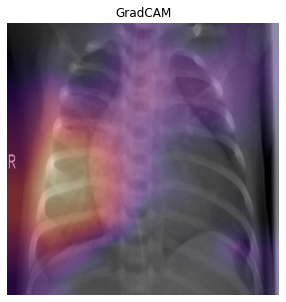

In [241]:
plt.rcParams['figure.figsize'] = [5, 5]
im_path=cv2.imread("/home/paa/COVID19-upgraded/Dataset/TRAIN/PNEUMONIA/112.jpeg")
im_path = cv2.resize(im_path,(300,300))
plt.imshow(im_path, cmap='gray')
plt.imshow(cam, cmap='magma', alpha=0.5)
plt.title("GradCAM")
plt.axis('off')
plt.savefig('GRADCAM.jpeg')
plt.show()